In [113]:
import os
import cv2
import random

import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms
from torch.utils.data import Dataset
from torch.utils.data import DataLoader

import pandas as pd
import numpy as np
from zipfile import ZipFile
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score    

import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.gridspec as gridspec
%matplotlib inline

Dataset 불러오기


In [114]:
# 데이터 경로
data_path = "C:/Users/alsgh/anaconda3/envs/torchsub/dataset/aerial-cactus-identification/"

labels = pd.read_csv(data_path + 'train.csv')
labels.head()
#dataset을 잘 불러왔는지 확인
#id엔 이미지번호, has_cactus엔 그 이미지에 선인장이 보이는지 true(1), false(0)으로 표시


,id,has_cactus
0,0004be2cfeaba1c0361d39e2b000257b.jpg,1
1,000c8a36845c0208e833c79c1bffedd1.jpg,1
2,000d1e9a533f62e55c289303b072733d.jpg,1
3,0011485b40695e9138e92d0b3fb55128.jpg,1
4,0014d7a11e90b62848904c1418fc8cf2.jpg,1


([<matplotlib.patches.Wedge at 0x1edbedc6a10>,
 [Text(-0.7793519565739233, 0.7762799287527649, 'Has cactus'),
  Text(0.7793519929142084, -0.776279892268666, "Has't cactus")],
 [Text(-0.4251010672221399, 0.42342541568332626, '75.1%'),
  Text(0.42510108704411365, -0.42342539578290866, '24.9%')])

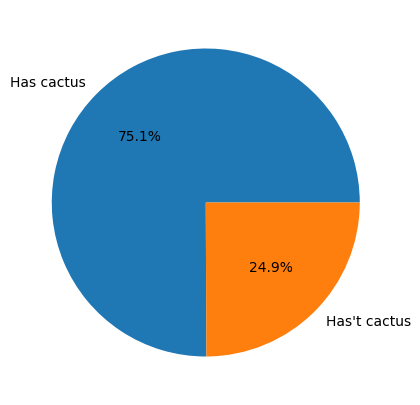

In [115]:
#Data Visualization

mpl.rc('font', size=10)
plt.figure(figsize =(5,5))

label = ['Has cactus', "Has't cactus"]
plt.pie(labels['has_cactus'].value_counts(), labels=label, autopct='%.1f%%')
#선인장 보임: 대략 75%


dataset 압축해제 .extractall()

In [116]:
with ZipFile(data_path + 'train.zip') as zipper:
    zipper.extractall()

with ZipFile(data_path + 'test.zip') as zipper:
    zipper.extractall()
    
num_train = len(os.listdir('train/'))#파일이름을 리스트로 출력해주는 .listdir
num_test = len(os.listdir('test/'))#그 이름으로 샘플 갯수를 출력

print(f'train samples :{num_train}')
print(f'test samples: {num_test}')
#train 17500개의 샘플, test 4000개 샘플
    

train samples :17500
test samples: 4000


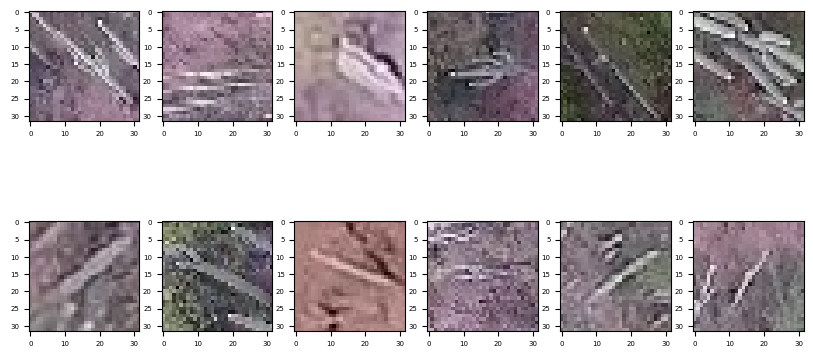

In [117]:
mpl.rc('font',size =5)
plt.figure(figsize =(10,5))
grid = gridspec.GridSpec(2, 6)#서브 플롯 2행 6열 생성

last_has_cactus_img_name = labels[labels['has_cactus']==1]['id'][-12:]
#선인장 이미지(1을 갖는)를 시각화(마지막 12개의 자료)

for idx, img_name in enumerate(last_has_cactus_img_name):
    img_path = 'train/' + img_name                 #이미지 파일 경로 
    image = cv2.imread(img_path)                   #이미지 파일 읽기 
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB) #이미지 색상 보정 
    #이미지 색상보정은 cv2.imread는 BRG로 이미지를 읽어오는데 RGB순서로 바꾸기 위해
    
    ax = plt.subplot(grid[idx])
    ax.imshow(image)                               

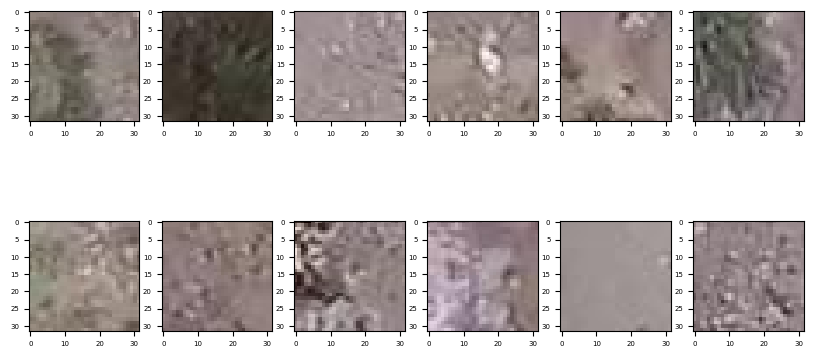

In [118]:
plt.figure(figsize =(10,5))
grid = gridspec.GridSpec(2, 6)#서브 플롯 2행 6열 생성

last_hast_cactus_img_name = labels[labels['has_cactus']==0]['id'][-12:]


for idx, img_name in enumerate(last_hast_cactus_img_name):
    img_path = 'train/' + img_name                  
    image = cv2.imread(img_path)                    
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  
    
    
    ax = plt.subplot(grid[idx])
    ax.imshow(image) 
    
#선인장이 안보이는 label=0데이터를 시각화(위 선인장과 비교)                      

In [119]:
image.shape
#이미지는 32*32*3 크기
#가로*세로*채널


(32, 32, 3)

Data split

In [120]:
#시드값을 고정(다시 실행시에도 같은 데이터를 이용하기위해)

seed = 50
os.environ['PYTHONHASHSEED'] =str(seed)
random.seed(seed)#파이썬 난수 고정
np.random.seed(seed)#넘파이 난수 고정
torch.manual_seed(seed)#cpu 난수 고정
torch.cuda.manual_seed(seed)#gpu 난수 고정
torch.cuda.manual_seed_all(seed)#gpu(멀티gpu) 난수 고정

torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
torch.backends.cudnn.enabled =False

In [121]:
#gpu설정

if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

device

device(type='cuda')

In [122]:
#데이터 분할
train, val =train_test_split(labels,
                              test_size =0.1,
                              stratify = labels['has_cactus'],
                              random_state = 50)

print('train sample:', len(train))
print('validation sample:', len(val))
#데이터가 잘 분할됐는지 확인(기존 17500샘플을 9:1로 분할)

 

train sample: 15750
validation sample: 1750


In [123]:
class ImageDataset(Dataset):
    
    def __init__(self, df, img_dir='./', transform=None):
        super().__init__() 
        self.df = df
        self.img_dir = img_dir
        self.transform = transform
    
 
    def __len__(self):
        return len(self.df)
    
    
    def __getitem__(self, idx):
        img_id = self.df.iloc[idx, 0]    #이미지 ID
        img_path = self.img_dir + img_id 
        image = cv2.imread(img_path)      
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB) 
        label = self.df.iloc[idx, 1]     #이미지 레이블(타깃값)

        if self.transform is not None:
            image = self.transform(image) #변환기가 있다면 이미지 변환
        return image, label 

In [124]:
#이미지 변환

transform = transforms.ToTensor()#텐서배열
#가로*세로*채널 --> 채널*가로*세로 ex)32,32,3-->3,32,32

#train set, val set(image ver)
dataset_train = ImageDataset(df=train, img_dir='train/',
                            transform =transform)
dataset_val = ImageDataset(df = val, img_dir='train/',
                          transform = transform)



In [125]:
#배치 할당(batch_size =32)
loader_train = DataLoader(dataset=dataset_train,
                          batch_size=32,
                          shuffle=True)
loader_valid = DataLoader(dataset=dataset_val,
                          batch_size=32,
                          shuffle=False)

Model(CNN)

In [126]:
#목표(3,32,32)의 이미지를 가지고 0과 1로 분류(output)

class Model(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.conv1 = nn.Conv2d(in_channels=3,out_channels=32,
                               kernel_size=3,padding=2)
        self.conv2 =nn.Conv2d(in_channels=32, out_channels=64,
                              kernel_size=3,padding=2)
        self.max_pool =nn.MaxPool2d(kernel_size=2)
        self.avg_pool =nn.AvgPool2d(kernel_size=2)
        self.fc =nn.Linear(in_features=64*4*4, out_features=2)
        #모델 구성 conv 2개의 층, max pool 1층, avg pool 1층
        #마지막에 fully connected
    def forward(self,x):
        x = self.max_pool(F.relu(self.conv1(x)))#Activation Function-Relu
        x = self.max_pool(F.relu(self.conv2(x)))
        x = self.avg_pool(x)
        x =x.view(-1,64*4*4)#앞에서부터 빈 공간 없이 채우기(평탄화)
        x = self.fc(x)
        #연산순서: 합성곱 1층->relu Function-> max_pool
        #합성곱 2층 -> relu Function -> max_pool
        #avg_pool -> 평탄화->fully connected
        return x
        

In [127]:
#model에 gpu할당

model = Model().to(device)
model

Model(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(2, 2))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(2, 2))
  (max_pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (avg_pool): AvgPool2d(kernel_size=2, stride=2, padding=0)
  (fc): Linear(in_features=1024, out_features=2, bias=True)
)

Tranining

In [128]:
#Loss Function
#classification문제라 crossEntropy사용
criterion = nn.CrossEntropyLoss()
#Optimizer
#SGD확률적 경사하강법, learning_rate = 0.01 설정
optimizer = torch.optim.SGD(model.parameters(), lr=0.01)

In [129]:
epochs = 10 

for epoch in range(epochs):
    epoch_loss = 0 #에폭별 손실값 초기화
    
    
    for images, labels in loader_train:
        #이미지, 레이블 데이터 배치를 gpu에 할당 
        images = images.to(device)
        labels = labels.to(device)
        
        #Optimizer 내 기울기 초기화
        optimizer.zero_grad()
        #순전파 : 이미지 데이터를 신경망 모델의 입력값으로 사용해 출력값 계산
        outputs = model(images)
        #손실 함수를 활용해 outputs와 labels의 손실값 계산
        loss = criterion(outputs, labels)
        # 현재 배치에서의 손실 추가
        epoch_loss += loss.item() #역전파 수행
        loss.backward()
        #가중치 갱신
        optimizer.step()
        
    # 훈련 데이터 손실값 출력
    print(f'에폭 [{epoch+1}/{epochs}] - 손실값: {epoch_loss/len(loader_train):.4f}')

에폭 [1/10] - 손실값: 0.5233
에폭 [2/10] - 손실값: 0.3453
에폭 [3/10] - 손실값: 0.2370
에폭 [4/10] - 손실값: 0.1984
에폭 [5/10] - 손실값: 0.1754
에폭 [6/10] - 손실값: 0.1666
에폭 [7/10] - 손실값: 0.1545
에폭 [8/10] - 손실값: 0.1439
에폭 [9/10] - 손실값: 0.1333
에폭 [10/10] - 손실값: 0.1299


성능 검증

In [138]:
#실제값과 예측확률을 담을 리스트 초기화
true_list = []
preds_list = []



In [137]:
model.eval()#model을 평가설정

with torch.no_grad():
    for images, labels in loader_valid:
        images = images.to(device)
        labels = labels.to(device)
        #배치 설정된 데이터를 gpu할당
        
        outputs = model(images)
        
        preds = torch.softmax(outputs.cpu(), dim=1)[:, 1]
        #예측확률 리스트에 저장
        true = labels.cpu()#실제값 저장
        
        preds_list.extend(preds)
        true_list.extend(true)

print(f'검증 데이터 ROC AUC : {roc_auc_score(true_list, preds_list):.4f}')
        

검증 데이터 ROC AUC : 0.9902
